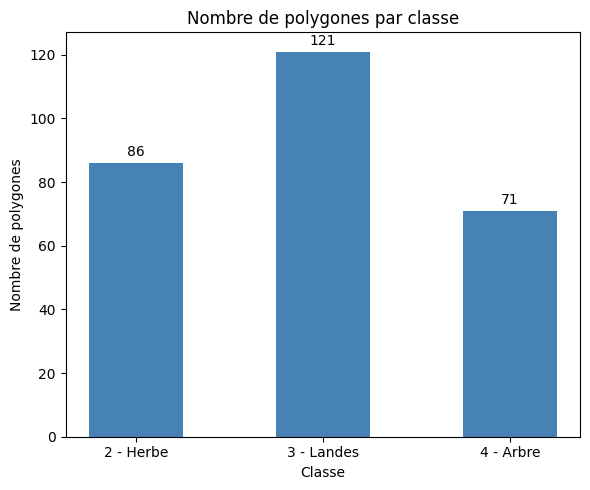

In [10]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Création du dossier
os.makedirs("results/figure", exist_ok=True)

# Chemin du fichier
out_1 = "results/figure/diag_baton_nb_poly_by_class.png"

# Lire ton shapefile
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")

# Dictionnaire de correspondance
classes_poly = {
    1: "1 - Sol Nu",
    2: "2 - Herbe",
    3: "3 - Landes",
    4: "4 - Arbre"
}

# Création de la colonne
gdf["classe"] = gdf["strate"].map(classes_poly)

# Comptage
counts_poly = gdf['classe'].value_counts().sort_index()

classes_poly = sorted(counts_poly.keys())
nb_poly = [counts_poly[c] for c in classes_poly]

classe_nom = {
    1: "Sol Nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre",
}

plt.figure(figsize=(6,5))
bars = plt.bar(classes_poly, nb_poly, color='steelblue', width=0.5)

for bar, nb in zip(bars, nb_poly):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(nb_poly)*0.01,
             str(nb), ha='center', va='bottom', fontsize=10)

plt.xticks(classes_poly, rotation=0)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.grid(False)
plt.tight_layout()
plt.savefig(out_1, bbox_inches='tight')
plt.show()

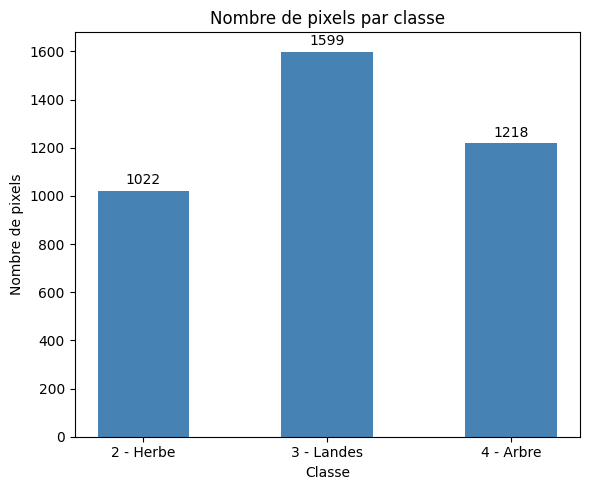

In [13]:
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from read_and_write import load_img_as_array  # si utile pour d'autres rasters

def rasterize_vector_in_memory(vector_file, ref_image, field_name):
    # Ouvrir l'image de référence
    ref_ds = gdal.Open(ref_image)
    gt = ref_ds.GetGeoTransform()
    proj = ref_ds.GetProjection()
    xsize = ref_ds.RasterXSize
    ysize = ref_ds.RasterYSize

    # Créer un raster en mémoire
    driver = gdal.GetDriverByName("MEM")
    out_ds = driver.Create(
        "",
        xsize,
        ysize,
        1,
        gdal.GDT_UInt16
    )
    out_ds.SetGeoTransform(gt)
    out_ds.SetProjection(proj)

    band = out_ds.GetRasterBand(1)
    band.Fill(0)  # fond = 0 (pas de classe)
    band.SetNoDataValue(0)

    # Ouvrir le vecteur
    vec_ds = ogr.Open(vector_file)
    layer = vec_ds.GetLayer()

    # Rasteriser dans le raster en mémoire
    gdal.RasterizeLayer(
        out_ds,
        [1],
        layer,
        options=[f"ATTRIBUTE={field_name}"]
    )

    # Récupérer le tableau NumPy
    array = band.ReadAsArray()

    # Fermer les datasets
    out_ds = None
    vec_ds = None

    return array

vector = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"
ref_image = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B02.tif"

# Rasterisation en mémoire
roi_array = rasterize_vector_in_memory(vector, ref_image, field_name="strate")
roi_array = roi_array[roi_array != 0]

# Comptage des pixels
counts_pixel = Counter(roi_array)
classes_pixel = sorted(counts_pixel.keys())
nb_pixel = [counts_pixel[c] for c in classes_pixel]
labels_pixel = [f"{c} - {classe_nom.get(c, 'Inconnu')}" for c in classes_pixel]

# Graphique
plt.figure(figsize=(6,5))
bars = plt.bar(classes_pixel, nb_pixel, color='steelblue', width=0.5)
for bar, nb in zip(bars, nb_pixel):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(nb_pixel)*0.01,
             str(nb), ha='center', va='bottom', fontsize=10)
plt.xticks(classes_pixel, labels_pixel, rotation=0)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.grid(False)
plt.tight_layout()
plt.savefig("results/figure/diag_baton_nb_pix_by_class.png", bbox_inches='tight')
plt.show()

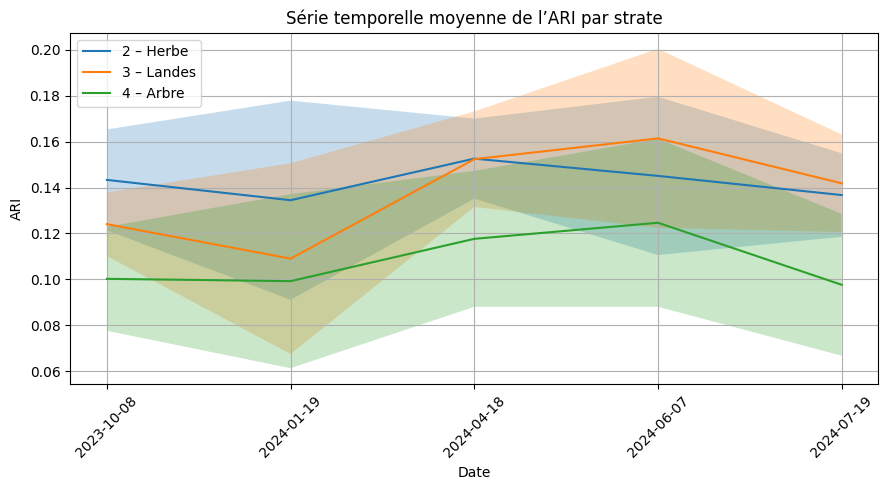

In [11]:
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt

def rasterize_vector_in_memory(vector_file, ref_image, field_name):
    ref_ds = gdal.Open(ref_image)
    gt = ref_ds.GetGeoTransform()
    proj = ref_ds.GetProjection()
    xsize = ref_ds.RasterXSize
    ysize = ref_ds.RasterYSize

    driver = gdal.GetDriverByName("MEM")
    out_ds = driver.Create("", xsize, ysize, 1, gdal.GDT_UInt16)
    out_ds.SetGeoTransform(gt)
    out_ds.SetProjection(proj)

    band = out_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    vec_ds = ogr.Open(vector_file)
    layer = vec_ds.GetLayer()

    gdal.RasterizeLayer(
        out_ds,
        [1],
        layer,
        options=[f"ATTRIBUTE={field_name}"]
    )

    array = band.ReadAsArray()

    out_ds = None
    vec_ds = None

    return array

def calculate_ari(b03, b05):
    mask = (b03 == 0) | (b05 == 0)
    ari = (1/b03 - 1/b05) / (1/b03 + 1/b05)
    ari[mask] = np.nan
    return ari.astype(np.float32)

dates = ["2024-07-19", "2024-06-07", "2024-04-18", "2024-01-19", "2023-10-08"]

b03_file = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif"
b05_file = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif"
strates_shp = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"
ref_image = b03_file

strate_labels = {
    1: "Sol Nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

ordre_strates = [2, 3, 4]  # comme demandé

roi_array = rasterize_vector_in_memory(
    strates_shp,
    ref_image,
    field_name="strate"
)

ds_b03 = gdal.Open(b03_file)
ds_b05 = gdal.Open(b05_file)

n_dates = ds_b03.RasterCount

ari_stack = []

for i in range(n_dates):
    b03 = ds_b03.GetRasterBand(i+1).ReadAsArray().astype(np.float32)
    b05 = ds_b05.GetRasterBand(i+1).ReadAsArray().astype(np.float32)
    ari = calculate_ari(b03, b05)
    ari_stack.append(ari)

ari_stack = np.array(ari_stack)

out_tif = "results/ARI_serie_temp.tif"

ref_ds = gdal.Open(ref_image)
geotrans = ref_ds.GetGeoTransform()
proj = ref_ds.GetProjection()
ysize, xsize = ari_stack.shape[1], ari_stack.shape[2]

driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(
    out_tif,
    xsize,
    ysize,
    ari_stack.shape[0],
    gdal.GDT_Float32,
    options=["COMPRESS=LZW"]
)

out_ds.SetGeoTransform(geotrans)
out_ds.SetProjection(proj)

for i in range(ari_stack.shape[0]):
    band = out_ds.GetRasterBand(i + 1)
    band.WriteArray(ari_stack[i])
    band.SetNoDataValue(np.nan)
    band.SetDescription(dates[i])

out_ds = None
ref_ds = None

ds_b03 = None
ds_b05 = None

mean_dict = {}
std_dict = {}

for s in ordre_strates:
    mask = roi_array == s

    if not np.any(mask):
        continue

    pixels = ari_stack[:, mask]
    mean_dict[s] = np.nanmean(pixels, axis=1)
    std_dict[s] = np.nanstd(pixels, axis=1)

dates_plot = dates[::-1]
x = np.arange(len(dates_plot))

plt.figure(figsize=(9,5))

for s in ordre_strates:
    if s not in mean_dict:
        continue

    plt.plot(
        x,
        mean_dict[s][::-1],
        label=f"{s} – {strate_labels[s]}"
    )

    plt.fill_between(
        x,
        mean_dict[s][::-1] - std_dict[s][::-1],
        mean_dict[s][::-1] + std_dict[s][::-1],
        alpha=0.25
    )

plt.xticks(x, dates_plot, rotation=45)
plt.xlabel("Date")
plt.ylabel("ARI")
plt.title("Série temporelle moyenne de l’ARI par strate")
plt.legend()
plt.grid(True)
plt.tight_layout()
out_figure = "results/figure/ARI_series.png"
plt.savefig(out_figure, bbox_inches="tight")
plt.show()